In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import selfies as sf
import mutations as mut
from functools import partial
import metrics as met
import functions as fn
from constants import *
from rdkit import Chem
from rdkit.Chem import Draw
import seaborn as sns
import pandas as pd
from datetime import datetime
import time
from tqdm import tqdm
from guacamol import standard_benchmarks
import numpy as np
import random
from copy import copy

c:\Users\marti\anaconda3\envs\thesis_3.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED_SIZE_LIST = [10, 100, 1000, 10000, 100000]
SEED_SIZE = SEED_SIZE_LIST[1]
SEED_LIST = [0,1,2]
SEED = SEED_LIST[2]
BUDGET_LIST = [100, 1000, 10000, 100000]
BUDGET = BUDGET_LIST[2]
GENERATIONS = 50




SAVE = True

# Single metric optimization

In [4]:
#f = standard_benchmarks.zaleplon_with_other_formula().objective.score()

metric_function_list = [
    partial(met.get_obj,objective="zale")
]
metrics = ['Metric 1']

In [5]:
mutation_function_list = [
    partial(mut.replacement)
    ,partial(mut.addition,fragment_size=1,rings=False)
    ,partial(mut.deletion,n=1)
]

In [6]:
current_dateTime = datetime.now()
time_format = f"{current_dateTime.date()}_{str(current_dateTime.hour).zfill(2)}-{str(current_dateTime.minute).zfill(2)}-{str(current_dateTime.second).zfill(2)}"


#for in for do:
for SEED in [SEED_LIST[2]]:
    for SEED_SIZE in SEED_SIZE_LIST[1:]:#[SEED_SIZE_LIST[2]]:#
        SEED_PATH = f"../data/seed_{SEED}/rand_{SEED_SIZE}.tsv"
        seed_df = pd.read_table(SEED_PATH) 
        initial_pop = fn.convert_seeds_to_df(seed_df,metric_function_list)
        for BUDGET in BUDGET_LIST[:4]:#[BUDGET_LIST[2]]:#
            setup_name = f"seed_{SEED}_rand_{SEED_SIZE}"
            file_name = f"{time_format}_{setup_name}_budget_{BUDGET}"

            first_generation_fraction = 0.05 #hyperparam
            N = int(BUDGET * first_generation_fraction) #1st generation size

            if len(initial_pop)>=N:
                initial_best = initial_pop.head(N)
            else:
                initial_best = initial_pop
            B0 = copy(BUDGET)

            #rest of hyperparams
            gen_history = pd.DataFrame(initial_best)
            temp_best = initial_best.copy(deep=True)
            crossover = True
            crossover_ratio = 0.2
            generation = 0
            cost_history = []
            next_generation_fraction = 0.05 #size of next generation; BUDGET * next_generation_fraction = new N
            initial_sample_fraction = 1.5 #initial_sample_size = len(temp_best) *  initial_sample_fraction ))
            minimal_next_generation_fraction = 0.0025
            max_gens = 500
            percent_best_fraction = 0.1
            include_initial_pop = False

            while (BUDGET > len(temp_best)):

                diversity = fn.get_last_diversity(temp_best)
                homogenity = 1 - diversity

                #crossover_ratio =  0.1#0.01 + ((diversity)/10)
                #print(f'crossover_ratio = {crossover_ratio}, N={N}')

                temp_pop, cost = fn.populate_from_df_batch(temp_best,N,metric_function_list,mutation_function_list,
                                            generation+1,include_seeds=True,fitness='Metric 1',crossover=crossover, crossover_type=0,
                                            crossover_ratio=crossover_ratio, fitness_proportional = True)
                cost_history.append(cost)
                BUDGET -= cost
                temp_pop.reset_index(drop=True,inplace=True)


                #if homogenity>0:
                #    temp_best = fn.get_percent_best(temp_pop, metrics,0.05+((homogenity**2)/2),minimize=False)
                #else:
                temp_best = fn.get_percent_best(temp_pop, metrics,percent_best_fraction,minimize=False)
                gen_history = pd.concat([gen_history,temp_best])
                
                
                
                if include_initial_pop:
                    initial_sample_size = int(np.ceil(  len(temp_best) *  initial_sample_fraction   ))
                    #initial_sample_size = 3 * int(np.ceil( len(temp_best)* homogenity**2  ))
                    #if initial_sample_size>len(initial_pop):
                    #    initial_sample_size = len(initial_pop)

                    temp_best = pd.concat([temp_best, initial_pop.sample(initial_sample_size)])

            
                #if homogenity==0:
                N = int(np.ceil(BUDGET * next_generation_fraction))
                    #print(f"homo {homogenity} , N {N}")
                #else:
                #    N = int(np.ceil(BUDGET * 0.1  * homogenity))
                    #print(f"no homo N {N}")
                #print(f"------- {N} ------- BUDGET / GENERATIONS {BUDGET / GENERATIONS} * homogenity {homogenity} + 0.1  = {(BUDGET / GENERATIONS) * homogenity + 0.1}")
                if N<=int(np.ceil(minimal_next_generation_fraction*B0)):
                    N = int(np.ceil(minimal_next_generation_fraction*B0))

                generation += 1
                if generation>=max_gens:
                    break


            if SAVE:
                gen_history.to_csv("out_exp/"+file_name+".csv")

###
latest_gen = gen_history[gen_history['Generation']==gen_history['Generation'].max()]
latest_gen.head()

100%|██████████| 132/132 [00:00<00:00, 478.26it/s]


,SMILES molecule,Generation,Metric 1
0,C1C(=CC=CC=1C)N(C(=O)C)C[C-]N1C(=[O+])C=NC=CC=...,161,0.655826
49,C12C=C1N([C-]CN(C(C)=O)C1C=C(C)C=CC=1)C(C=NC=C...,161,0.655826
56,N1=CC(N([C-]CN(C(=O)C)C2=CC=CC(=C2)C)C2C(C=2)=...,161,0.655826
55,N(C[C-]N1C2=CC2=CC=CN=CC1=[O+])(C(=O)C)C1C=C(C...,161,0.655826
54,C1(N(C[C-]N2C3C(=CC=CN=CC2=[O+])C=3)C(C)=O)C=C...,161,0.655826


Median score


<Axes: >

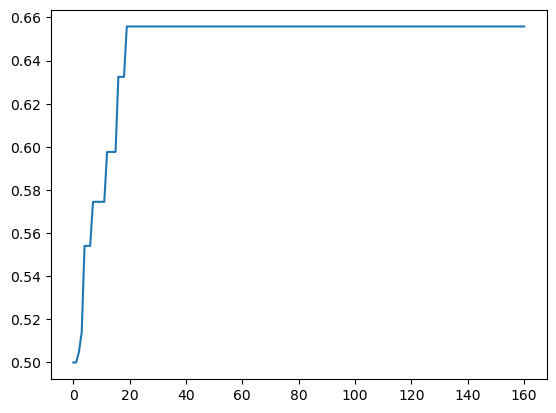

In [7]:
dayta = [np.max(gen_history[gen_history['Generation']==i]['Metric 1']) for i in range(0,gen_history['Generation'].max())]
sns.lineplot(dayta)

Diversity

<Axes: >

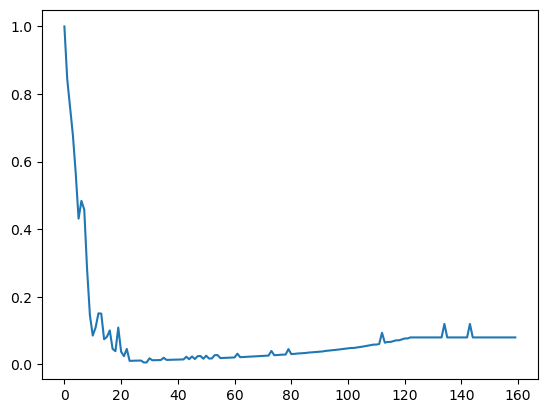

In [8]:
dayta = [len(pd.unique(gen_history[gen_history['Generation']==i]['SMILES molecule'].apply(lambda x: fn.canonicalize_smiles(x))))/len((gen_history[gen_history['Generation']==i]['SMILES molecule'])) for i in range(1,gen_history['Generation'].max())]
sns.lineplot(dayta)

# BEST size

<Axes: >

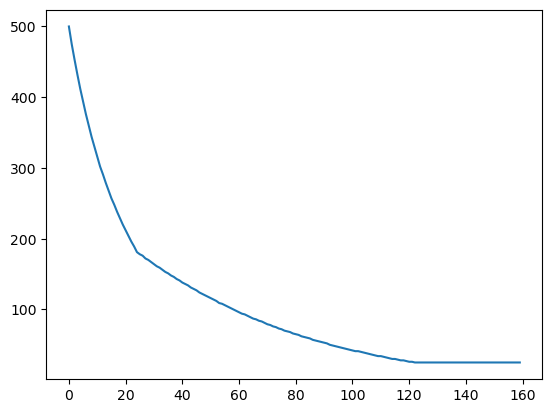

In [9]:
dayta = [len((gen_history[gen_history['Generation']==i]['SMILES molecule'])) for i in range(1,gen_history['Generation'].max())]
sns.lineplot(dayta)

<Axes: >

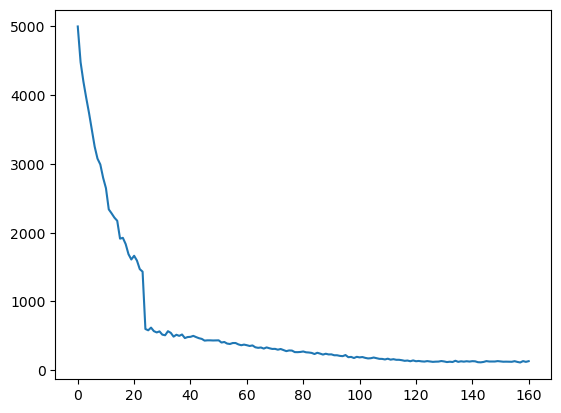

In [10]:
sns.lineplot(cost_history)

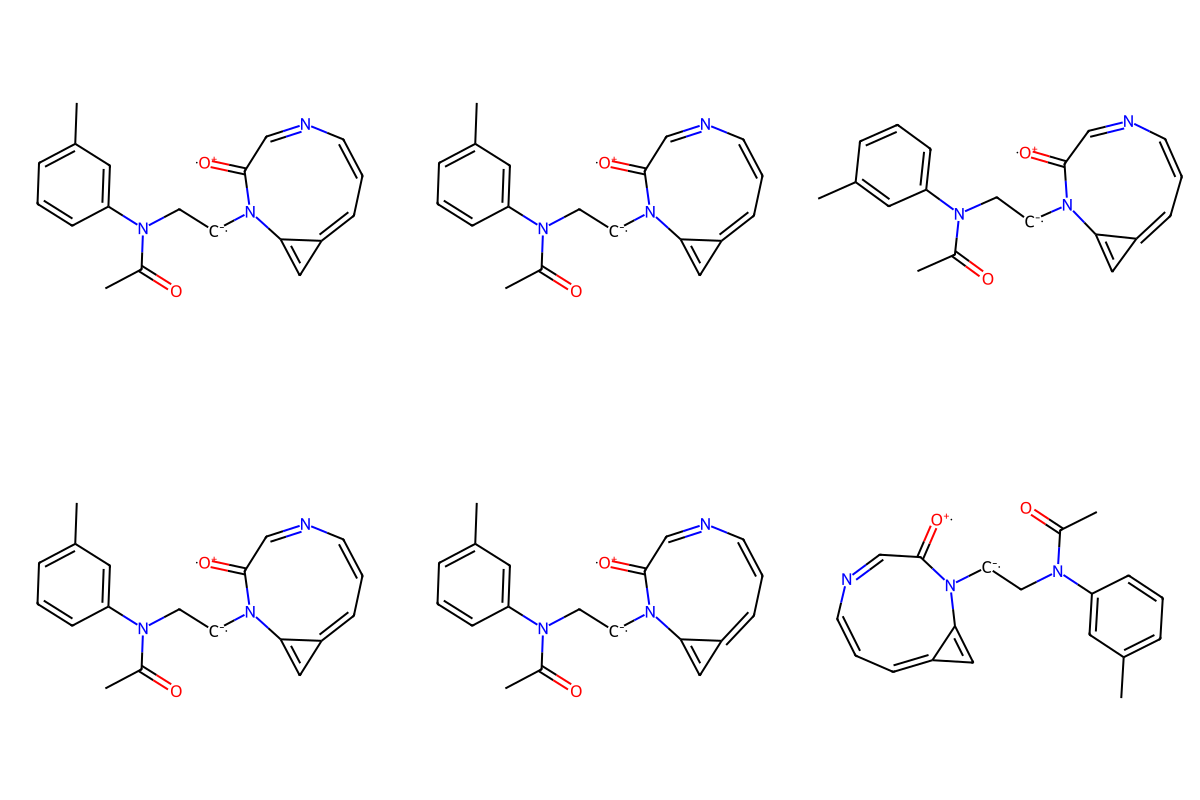

In [11]:
latest_gen_mol = [Chem.MolFromSmiles(molecule) for molecule in set(latest_gen["SMILES molecule"][:6])]
img = Draw.MolsToGridImage(latest_gen_mol, 
                           molsPerRow=3,
                           subImgSize=(400, 400), 
                           maxMols=len(latest_gen),
                           legends=None)
display(img)

In [12]:
plot_metric_generations = False
if plot_metric_generations:
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import norm


    generations = gen_history['Generation'].unique()
    generations.sort()  # Make sure generations are sorted

    pal = sns.cubehelix_palette(len(generations), rot=-.25, light=.7)

    # Initialize a FacetGrid object
    g = sns.FacetGrid(gen_history, row="Generation", hue="Generation", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "Metric 1", clip_on=False, shade=True, alpha=1, lw=1.5, bw_method=.2)
    #g.map(sns.kdeplot, "Metric 1", clip_on=False, color="w", lw=2, bw_method=.2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "Metric 1")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.0)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.xlabel('Zaleplon similarity ', fontsize=14)
    plt.ylabel('Generation', fontsize=14)

    plt.show()
